In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras

Para utilizar el aprendizaje por transferencia, necesitamos un modelo base a partir del cual podamos utilizar las capas de extracción de características entrenadas. El modelo resnet es un clasificador de imágenes basado en CNN que ha sido entrenado previamente utilizando un enorme conjunto de datos de imágenes de canales de 3 colores de 224x224 píxeles. Creemos una instancia con algunos pesos previamente entrenados, excluyendo su capa final de predicción. Los modelos preentrenados como ResNet50 ya han aprendido características útiles de un conjunto de datos grande como ImageNet, lo que puede mejorar el rendimiento de nuestro modelo en nuestro conjunto de datos específico.

In [20]:
#base model
def load_base_model():
    base_model = keras.applications.resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    return base_model

base_model = load_base_model()

- Nombre de la capa: Cada fila muestra el nombre de una capa específica en el modelo ResNet50.
- Forma de salida: Indica las dimensiones de la salida de cada capa. Por ejemplo, (None, 7, 7, 512) significa que la salida tiene una forma de (ancho, alto, profundidad) de (7, 7, 512).
- Parámetros entrenables: Es la cantidad de parámetros que pueden ser entrenados en cada capa. Estos parámetros son los que se ajustan durante el entrenamiento del modelo para minimizar la pérdida.
- Nombre de la capa de origen: En algunas filas, se indica el nombre de la capa de la cual proviene la salida de la capa actual. Esto muestra cómo se conectan las capas entre sí.


Utilizamos ImageDataGenerator para cargar y preprocesar las imágenes, lo que facilita la carga de imágenes de forma eficiente y su preparación para el entrenamiento de la red. Normalizamos los valores de los píxeles de las imágenes a un rango entre 0 y 1, lo que puede ayudar a mejorar la convergencia del modelo durante el entrenamiento. Dividimos las imágenes en conjuntos de entrenamiento y validación, especificando qué porcentaje se destinará a cada uno. Además, configuramos los generadores de datos para que redimensionen las imágenes al tamaño requerido por el modelo preentrenado y las dividan en lotes para un procesamiento eficiente durante el entrenamiento. 

In [21]:
#Preparamos nuestras imágenes

def prepare_data(data_folder, pretrained_size, batch_size):
    print("Getting Data...")
    datagen = ImageDataGenerator(rescale=1./255, #normalizamos el valor de los pixeles
                                validation_split=0.2) #20% de laa imágenes para la validación

    print("Preparing training dataset...")
    train_generator = datagen.flow_from_directory(
        data_folder,
        target_size=pretrained_size, #cambiar el tamaño para que coincida con la entrada esperada del modelo
        batch_size=batch_size,
        class_mode='categorical',
        subset='training') #establecer como datos de entrenamiento

    print("Preparing validation dataset...")
    validation_generator = datagen.flow_from_directory(
        data_folder,
        target_size=pretrained_size, #cambiar el tamaño para que coincida con la entrada esperada del modelo
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation') #establecer como datos de validación

    classnames = list(train_generator.class_indices.keys())
    print("class names: ", classnames)

    return train_generator, validation_generator, classnames



data_folder = 'dataframe/logo'
pretrained_size = (224,224)
batch_size = 30

train_generator, validation_generator, classnames = prepare_data(data_folder, pretrained_size, batch_size)

Getting Data...
Preparing training dataset...
Found 750 images belonging to 3 classes.
Preparing validation dataset...
Found 186 images belonging to 3 classes.
class names:  ['AtleticoMadrid', 'Dortmund', 'Real Madrid']


 A continuación, congelamos las capas del modelo base preentrenado para evitar que se actualicen durante el entrenamiento de nuestro nuevo modelo. Luego, creamos una nueva capa de predicción que consiste en una capa de aplanamiento (Flatten) seguida de una capa densa con una función de activación softmax, que produce probabilidades de pertenencia a cada clase. Combinamos las capas del modelo base con la capa de predicción utilizando la clase Model de Keras. Posteriormente, compilamos el modelo especificando la función de pérdida, el optimizador y las métricas que se utilizarán durante el entrenamiento y la evaluación del modelo. Finalmente, imprimimos un resumen del modelo completo, que incluye tanto las capas del modelo base como la nueva capa de predicción que hemos añadido.

In [13]:
#Creamos una capa de predicción
from tensorflow.keras import applications
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense

#Congelamos las capas ya entrenadas en el modelo base
for layer in base_model.layers:
    layer.trainable = False

#Crear capa de predicción para clasificación de nuestras imágenes
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classnames), activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

#Compilamos el modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Imprimimos el modelo completo, que incluirá las capas del modelo base más la capa densa que agregamos.
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,888,771 (91.13 MB)

 Trainable params: 301,059 (1.15 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


Entrenamos el modelo. Durante el entrenamiento, el modelo ajustará sus pesos para minimizar la función de pérdida en los datos de entrenamiento, mientras que se monitorea su desempeño en los datos de validación para evitar el sobreajuste. 

In [14]:
#Entrenamos el modelo
num_epochs = 3
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/3


/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4715 - loss: 5.5209 - val_accuracy: 0.7556 - val_loss: 0.4807
Epoch 2/3


2024-04-22 09:49:03.348797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.2830
Epoch 3/3


2024-04-22 09:49:03.559980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8682 - loss: 0.3517 - val_accuracy: 0.9611 - val_loss: 0.1012


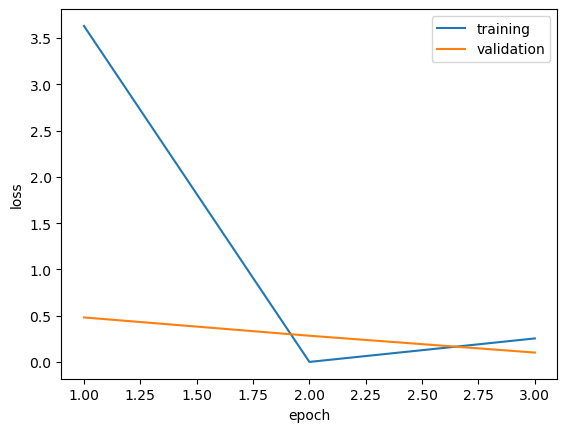

In [15]:
#Evaluamos el modelo
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Generating predictions from validation data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


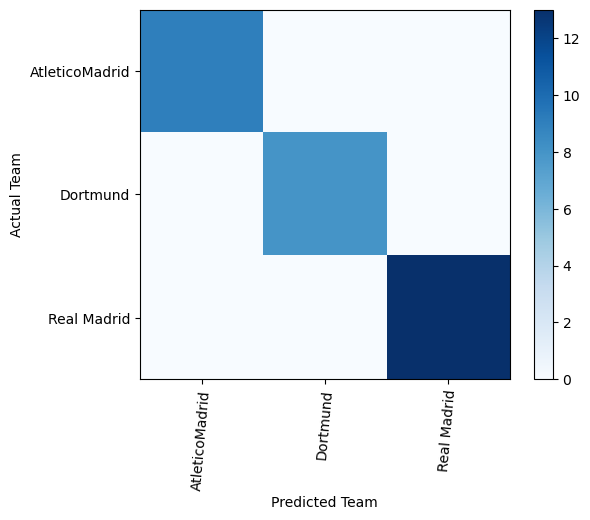

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix

print("Generating predictions from validation data...")
#Obtener las matrices de imágenes y etiquetas para el primer lote de datos de validación
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

#Usamos el modelo para predecir
class_probabilities = model.predict(x_test)

#El modelo devuelve un valor de probabilidad para cada clase.
#La que tiene mayor probabilidad es la clase predicha.
predictions = np.argmax(class_probabilities, axis=1)

#Las etiquetas reales están hot encoded (por ejemplo, [0 1 0]), así que obtenemos la que tiene el valor 1
true_labels = np.argmax(y_test, axis=1)

#Trazamos la matriz de ocnfusión
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Team")
plt.ylabel("Actual Team")
plt.show()

In [17]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 802ms/step - accuracy: 0.9772 - loss: 0.0878
Test loss: 0.10627501457929611
Test accuracy: 0.9623655676841736
